# Bank Churn Prediction

Churn prediction systems primarily focus on customer behavior to identify specific customers who are likely to churn out and indicate reasons for the churn.  
 
Such a system would aid marketing to develop effective retention strategies, increasing overall customer lifetime value, and assisting in growing the company’s market value.  

For many companies, this is an important prediction. This is because acquiring new customers often costs more than retaining existing ones. This is the metric that determines the success or failure of a business. Successful customer retention increases the customer’s average lifetime value, making all future sales more valuable and improving unit margins.

Once you’ve identified customers at risk of churn, you need to know exactly what marketing efforts you should make with each customer to maximize their likelihood of staying.



# Model Building

In [27]:
import pandas as pd
import seaborn as sns
import math
import numpy as np
from scipy.stats import lognorm
import statsmodels.api as sm
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score



In [4]:
df = pd.read_csv('cleaned_df.csv') #cleaned dataset
df.head()

,Unnamed: 0,gender,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,country_Germany,country_Spain,age_encoded,cs_encoded
0,0,1,2,0.00,1,1,1,101348.88,1,0,0,2,1
1,1,1,1,83807.86,1,0,1,112542.58,0,0,1,1,1
2,2,1,8,159660.80,3,1,0,113931.57,1,0,0,2,0
3,3,1,1,0.00,2,0,0,93826.63,0,0,0,1,2
4,4,1,2,125510.82,1,1,1,79084.10,0,0,1,2,4


In [3]:
df = df.sample(frac=1, random_state = 1).reset_index() #shuffle rows

In [6]:
df.columns

Index(['Unnamed: 0', 'gender', 'tenure', 'balance', 'products_number',
       'credit_card', 'active_member', 'estimated_salary', 'churn',
       'country_Germany', 'country_Spain', 'age_encoded', 'cs_encoded'],
      dtype='object')

In [7]:
df = df.drop(df[['Unnamed: 0']], axis = 1) #drop unnecessary columns

In [8]:
df.columns

Index(['gender', 'tenure', 'balance', 'products_number', 'credit_card',
       'active_member', 'estimated_salary', 'churn', 'country_Germany',
       'country_Spain', 'age_encoded', 'cs_encoded'],
      dtype='object')

In [9]:
X = df.drop('churn', axis = 1) #Dependent variables
y = df['churn'] #target variable

In [10]:
# train_test_split
# Test size = 30%
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 29)

In [14]:
#Feature Scaling using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

mm = MinMaxScaler()

X_train = pd.DataFrame(mm.fit_transform(X_train))
X_test = pd.DataFrame(mm.transform(X_test))

In [12]:
ftrain = y_train.value_counts()[1]/len(y_train)
print('Percentage of churn cases in training set : {:.2%}'.format(ftrain))

Percentage of churn cases in training set : 20.04%


In [13]:
ftest = y_test.value_counts()[1]/len(y_test) 
print('Percentage of churn cases in testing set : {:.2%}'.format(ftest))

Percentage of churn cases in testing set : 21.13%


We have unequal distribution of churn class in the dataset i.e. the no. of data points in the non - churn class (y = 0) is very large compared to that of the churn class (y = 1).

The minority/positive churn class is the class of interest and we aim to achieve the best results in this class.

Resampling data is one of the most preferred approache to deal with an imbalanced dataset. There are broadly two types of methods for this i) Undersampling ii) Oversampling. 

In most cases, oversampling is preferred over undersampling techniques. The reason being, in undersampling we tend to remove instances from data that may be carrying some important information. 

Here we implement the SMOTE oversampling technique.

In [15]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state = 9)

X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())

print('AFTER OVERSAMPLING, COUNT OF LABEL 1 and 0')
print(sum(y_train_res == 1)) # AFTER OVERSAMPLING, COUNT OF LABEL 1 (positive churn cases)
print(sum(y_train_res == 0))

AFTER OVERSAMPLING, COUNT OF LABEL 1 and 0
5597
5597


#### ML model evaluation approach:

Precision and recall are terms used to describe how accurate a machine learning algorithms is – in the case of churn

- Precision – Of all the users that the algorithm predicts will churn, how many of them do actually churn? 

- Recall – What percentage of users that end up churning does the algorithm successfully find?


As the dataset is imbalanced, both precision and recall are important for evaluating the performance of a churn prediction algorithm. However, as precision & recall are inversely related there will always be a tradeoff between the two.

But in this case a higher priority will be given to recall as the bank's marketing team would like to reach out to anyone in danger of churning. They would be less concerned with users who are not in danger of churning receiving a marketing message. As marketing costs also have to be concidered a very low precision won't be ideal.

## Logistic Regression

In [16]:
# Simple Logistic Regression
lr = LogisticRegression()
lr.fit(X_train_res, y_train_res.ravel())

prediction = lr.predict(X_test)
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.90      0.72      0.80      2366
           1       0.40      0.70      0.51       634

    accuracy                           0.72      3000
   macro avg       0.65      0.71      0.66      3000
weighted avg       0.80      0.72      0.74      3000



In [19]:
print('Training Score', lr.score(X_train_res, y_train_res))
print('Testing Score', lr.score(X_test, y_test))

Training Score 0.7152939074504199
Testing Score 0.7183333333333334


In [20]:
print('Recall: %.3f' % recall_score(y_test, prediction))
print('Precision: %.3f' % precision_score(y_test, prediction))
print('Accuracy: %.3f' % accuracy_score(y_test, prediction))

Recall: 0.700
Precision: 0.404
Accuracy: 0.718


High Accuracy and Recall but low precision

In [21]:
param_grid = {'C': [0.001, 0.1, 0.5, 0.75, 1,1.5], 'max_iter': [100, 150, 200, 250], 'penalty':['l1', 'l2'], 'tol':[0.00001,0.0001,0.000001]}

lr_Grid = GridSearchCV(LogisticRegression(solver='lbfgs'), param_grid, cv=5, refit=True, verbose=0)
lr_Grid.fit(X_train_res,y_train_res.ravel())

lr_Grid.best_params_

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
360 fits failed out of a total of 720.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
360 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueError: Solve

{'C': 0.001, 'max_iter': 100, 'penalty': 'l2', 'tol': 1e-05}

In [23]:
lr_g = LogisticRegression(C= 0.001, penalty="l2", max_iter = 100, tol = 1e-05)
lr_g.fit(X_train_res,y_train_res)

print("Training score:",lr_g.score(X_train_res,y_train_res))
print("Testing score:",lr_g.score(X_test,y_test))

Training score: 0.7157405753082008
Testing score: 0.7306666666666667


Model performs better on test set

In [24]:
y_train_pred = lr_g.predict(X_train)
y_test_pred = lr_g.predict(X_test)

print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.91      0.73      0.81      2366
           1       0.42      0.72      0.53       634

    accuracy                           0.73      3000
   macro avg       0.66      0.73      0.67      3000
weighted avg       0.80      0.73      0.75      3000



In [25]:
print('Recall: %.3f' % recall_score(y_test, y_test_pred))
print('Precision: %.3f' % precision_score(y_test, y_test_pred))
print('Accuracy: %.3f' % accuracy_score(y_test, y_test_pred))

Recall: 0.722
Precision: 0.420
Accuracy: 0.731


The logistic model performed better after grid search cv.  

High Accuracy and Recall. However precision should preferable be higher

## Decision Tree and Random Forest

In [65]:
dt_model = DecisionTreeClassifier(random_state = 101)
dt_model.fit(X_train_res, y_train_res)
dt_pred_test = dt_model.predict(X_test)

dt_conf_matrix = confusion_matrix(y_test, dt_pred_test)

print("confusion matric: \n", dt_conf_matrix)
print("---------------------------------")
print("Classification report : \n", classification_report(y_test, dt_pred_test))


confusion matric: 
 [[1995  371]
 [ 294  340]]
---------------------------------
Classification report : 
               precision    recall  f1-score   support

           0       0.87      0.84      0.86      2366
           1       0.48      0.54      0.51       634

    accuracy                           0.78      3000
   macro avg       0.67      0.69      0.68      3000
weighted avg       0.79      0.78      0.78      3000



In [29]:
print("Training score:",lr_g.score(X_train_res,y_train_res))
print("Testing score:",lr_g.score(X_test,y_test))
print('Recall: %.3f' % recall_score(y_test, dt_pred_test))
print('Precision: %.3f' % precision_score(y_test, dt_pred_test))
print('Accuracy: %.3f' % accuracy_score(y_test, dt_pred_test))

Training score: 0.7157405753082008
Testing score: 0.7306666666666667
Recall: 0.536
Precision: 0.478
Accuracy: 0.778


Low Precision and Recall.

In [30]:
#Bagging
from sklearn.ensemble import BaggingClassifier

# max_samples: maximum size 0.5=50% of each sample taken from the full dataset
# max_features: maximum of features 1=100% 
# n_estimators: number of decision trees 

bg=BaggingClassifier(DecisionTreeClassifier(),max_samples=0.5,max_features=1.0,n_estimators=10)
bg.fit(X_train_res, y_train_res)
print("score on test: " + str(bg.score(X_test, y_test)))
print("score on train: "+ str(bg.score(X_train_res, y_train_res)))

score on test: 0.8393333333333334
score on train: 0.9576558870823656


In [31]:
bg_pred_test = bg.predict(X_test)

bg_conf_matrix = confusion_matrix(y_test, bg_pred_test)

print("confusion matric: \n", bg_conf_matrix)
print("---------------------------------")
print("Classification report : \n", classification_report(y_test, bg_pred_test))

confusion matric: 
 [[2191  175]
 [ 307  327]]
---------------------------------
Classification report : 
               precision    recall  f1-score   support

           0       0.88      0.93      0.90      2366
           1       0.65      0.52      0.58       634

    accuracy                           0.84      3000
   macro avg       0.76      0.72      0.74      3000
weighted avg       0.83      0.84      0.83      3000



In [32]:
print('Recall: %.3f' % recall_score(y_test, bg_pred_test))
print('Precision: %.3f' % precision_score(y_test, bg_pred_test))
print('Accuracy: %.3f' % accuracy_score(y_test, bg_pred_test))

Recall: 0.516
Precision: 0.651
Accuracy: 0.839


Low Recall; Precision is higher than recall

In [33]:
# Random Forest

rf_model = RandomForestClassifier(random_state = 99)
rf_model.fit(X_train_res, y_train_res)

rf_pred_test = rf_model.predict(X_test)
rf_conf_matrix = confusion_matrix(y_test, rf_pred_test)

print("confusion matric: \n", rf_conf_matrix)
print("---------------------------------")
print("Classification report : \n", classification_report(y_test, rf_pred_test))

confusion matric: 
 [[2218  148]
 [ 312  322]]
---------------------------------
Classification report : 
               precision    recall  f1-score   support

           0       0.88      0.94      0.91      2366
           1       0.69      0.51      0.58       634

    accuracy                           0.85      3000
   macro avg       0.78      0.72      0.74      3000
weighted avg       0.84      0.85      0.84      3000



In [34]:
print("Training score:",lr_g.score(X_train_res,y_train_res))
print("Testing score:",lr_g.score(X_test,y_test))
print('Recall: %.3f' % recall_score(y_test, dt_pred_test))
print('Precision: %.3f' % precision_score(y_test, dt_pred_test))
print('Accuracy: %.3f' % accuracy_score(y_test, dt_pred_test))

Training score: 0.7157405753082008
Testing score: 0.7306666666666667
Recall: 0.536
Precision: 0.478
Accuracy: 0.778


Recall > Precision

In [41]:
# Fine tuning with RandomizedSearchCV

params = {
    'n_estimators': [10,20,50,100,120,150,200,250,300,350,400,450],
    'criterion':['gini', 'entropy'],
    'max_depth': [3,4,5],
    'min_samples_split':[2,3,4]}

In [45]:
from sklearn.model_selection import RandomizedSearchCV
rsearch = RandomizedSearchCV(rf_model, param_distributions = params, n_iter = 10, n_jobs = -1, scoring = 'recall', cv =5, verbose = 5)

In [46]:
rsearch

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=99),
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, 4, 5],
                                        'min_samples_split': [2, 3, 4],
                                        'n_estimators': [10, 20, 50, 100, 120,
                                                         150, 200, 250, 300,
                                                         350, 400, 450]},
                   scoring='recall', verbose=5)

In [47]:
rsearch.fit(X_train_res, y_train_res)
rsearch.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'n_estimators': 200,
 'min_samples_split': 4,
 'max_depth': 5,
 'criterion': 'entropy'}

In [48]:
# Random Forest tuned

rf_tuned = RandomForestClassifier(n_estimators= 200,min_samples_split = 4, max_depth= 5, criterion='entropy', random_state =999)
rf_tuned.fit(X_train_res, y_train_res)

rft_pred_test = rf_tuned.predict(X_test)
rft_conf_matrix = confusion_matrix(y_test, rft_pred_test)

print("confusion matric: \n", rft_conf_matrix)
print("---------------------------------")
print("Classification report : \n", classification_report(y_test, rft_pred_test))

confusion matric: 
 [[2016  350]
 [ 237  397]]
---------------------------------
Classification report : 
               precision    recall  f1-score   support

           0       0.89      0.85      0.87      2366
           1       0.53      0.63      0.57       634

    accuracy                           0.80      3000
   macro avg       0.71      0.74      0.72      3000
weighted avg       0.82      0.80      0.81      3000



In [49]:
print("Training score:",rf_tuned.score(X_train_res,y_train_res))
print("Testing score:",rf_tuned.score(X_test,y_test))
print('Recall: %.3f' % recall_score(y_test, rft_pred_test))
print('Precision: %.3f' % precision_score(y_test, rft_pred_test))
print('Accuracy: %.3f' % accuracy_score(y_test, rft_pred_test))

Training score: 0.8289262104698946
Testing score: 0.8043333333333333
Recall: 0.626
Precision: 0.531
Accuracy: 0.804


Good Scoring with good trad off between scores.

In [51]:
# GridSearchCV
from sklearn.model_selection import GridSearchCV


criteria = ["gini", "entropy"]      #criteria to be tested
min_sample_split_range = [2,3,4] #min sample split to be tested
max_depth_range = [3,4, 5, 6]  #max depth to be tested
min_samples_leaf_range = [1, 5, 7] #min samples in the leaf to be tested
min_leaf_nodes_range = [None, 5, 10, 20]    #min leaf nodes to be tested

param_grid = {"criterion": criteria,
              "min_samples_split": min_sample_split_range,
              "max_depth": max_depth_range,
              "min_samples_leaf": min_samples_leaf_range,
              "max_leaf_nodes": min_leaf_nodes_range
                }

grid = GridSearchCV(estimator=DecisionTreeClassifier(), 
                    param_grid=param_grid, 
                    cv = 5, 
                    scoring='recall', 
                    refit=True)     #setting grid with estimator

In [52]:
grid.fit(X_train_res, y_train_res) 

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 4, 5, 6],
                         'max_leaf_nodes': [None, 5, 10, 20],
                         'min_samples_leaf': [1, 5, 7],
                         'min_samples_split': [2, 3, 4]},
             scoring='recall')

In [53]:
print("Accuracy of the tuned model: %.4f" %grid.best_score_)
print(grid.best_params_)

Accuracy of the tuned model: 0.7883
{'criterion': 'gini', 'max_depth': 4, 'max_leaf_nodes': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [54]:
# Random Forest tuned gs

rf_gs = RandomForestClassifier(max_depth = 4, max_leaf_nodes = 5, min_samples_leaf = 1,min_samples_split = 2, criterion='gini', random_state =999)

rf_gs.fit(X_train_res, y_train_res)

rfg_pred_test = rf_gs.predict(X_test)
rfg_conf_matrix = confusion_matrix(y_test, rfg_pred_test)

print("confusion matric: \n", rfg_conf_matrix)
print("---------------------------------")
print("Classification report : \n", classification_report(y_test, rfg_pred_test))

confusion matric: 
 [[1954  412]
 [ 214  420]]
---------------------------------
Classification report : 
               precision    recall  f1-score   support

           0       0.90      0.83      0.86      2366
           1       0.50      0.66      0.57       634

    accuracy                           0.79      3000
   macro avg       0.70      0.74      0.72      3000
weighted avg       0.82      0.79      0.80      3000



In [55]:
print("Training score:",rf_gs.score(X_train_res,y_train_res))
print("Testing score:",rf_gs.score(X_test,y_test))
print('Recall: %.3f' % recall_score(y_test, rfg_pred_test))
print('Precision: %.3f' % precision_score(y_test, rfg_pred_test))
print('Accuracy: %.3f' % accuracy_score(y_test, rfg_pred_test))

Training score: 0.8067714847239592
Testing score: 0.7913333333333333
Recall: 0.662
Precision: 0.505
Accuracy: 0.791


Better model as Training and Testing scores dont differ much, 

And Recall is relatively higher

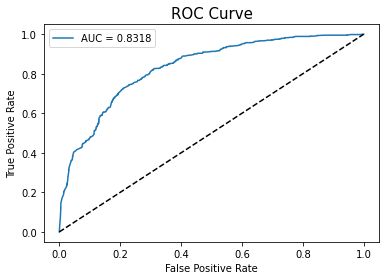

In [56]:
from sklearn.metrics import roc_curve, roc_auc_score

y_pred_proba = rf_gs.predict_proba(X_test)[:][:,1]
df_actual_predicted = pd.concat([pd.DataFrame(np.array(y_test), columns=['y_actual']), pd.DataFrame(y_pred_proba, columns=['y_pred_proba'])], axis=1)
df_actual_predicted.index = y_test.index
fpr, tpr, tr = roc_curve(df_actual_predicted['y_actual'], df_actual_predicted['y_pred_proba'])
auc = roc_auc_score(df_actual_predicted['y_actual'], df_actual_predicted['y_pred_proba'])

plt.plot(fpr, tpr, label='AUC = %0.4f' %auc)
plt.plot(fpr, fpr, linestyle = '--', color='k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve', size = 15)
plt.legend()

In [91]:
f = rf_gs.feature_importances_
col = np.array(X.columns)
Importance = pd.DataFrame({'Importance':rf_gs.feature_importances_*100}, index = col)
Imp = Importance.sort_values(by = 'Importance', axis = 0, ascending = False)



In [92]:
Imp.head(11)

,Importance
age_encoded,40.137365
products_number,35.900798
balance,8.327155
active_member,7.362986
country_Germany,3.858264
cs_encoded,3.394731
gender,0.615494
estimated_salary,0.248057
tenure,0.155150
credit_card,0.000000


## XGBoost

In [64]:
from xgboost import XGBClassifier
xgb_model = XGBClassifier()
xgb_model.fit(X_train_res, y_train_res)
y_pred = xgb_model.predict(X_test)


rft_conf_matrix = confusion_matrix(y_test, y_pred)

print("confusion matric: \n", rft_conf_matrix)
print("---------------------------------")
print("Classification report : \n", classification_report(y_test, y_pred))

confusion matric: 
 [[2230  136]
 [ 335  299]]
---------------------------------
Classification report : 
               precision    recall  f1-score   support

           0       0.87      0.94      0.90      2366
           1       0.69      0.47      0.56       634

    accuracy                           0.84      3000
   macro avg       0.78      0.71      0.73      3000
weighted avg       0.83      0.84      0.83      3000



In [66]:
print("Training score:",xgb_model.score(X_train_res,y_train_res))
print("Testing score:",xgb_model.score(X_test,y_test))
print('Recall: %.3f' % recall_score(y_test, y_pred))
print('Precision: %.3f' % precision_score(y_test, y_pred))
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

Training score: 0.9581918885117027
Testing score: 0.843
Recall: 0.472
Precision: 0.687
Accuracy: 0.843


Model overfillting

In [67]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [68]:
params={
    "learning_rate":[0.05,0.10,0.15,0.20,0.25,0.30],
    "max_depth":[2,3,4,5,6,8],
    "min_child_weight":[1,3,5,6],
    "gamma":[0.0,0.1,0.2,0.3,0.4],
    "colsample_bytree":[0.3,0.4,0.5,0.7]}

xgb = XGBClassifier()
clf = RandomizedSearchCV(xgb,param_distributions=params,n_iter=10,scoring='f1',cv=5,verbose=3, random_state=42)
clf.fit(X_train_res,y_train_res)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.3, max_depth=8, min_child_weight=1;, score=0.478 total time=   0.7s
[CV 2/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.3, max_depth=8, min_child_weight=1;, score=0.905 total time=   0.7s
[CV 3/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.3, max_depth=8, min_child_weight=1;, score=0.963 total time=   0.7s
[CV 4/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.3, max_depth=8, min_child_weight=1;, score=0.952 total time=   0.7s
[CV 5/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.3, max_depth=8, min_child_weight=1;, score=0.951 total time=   0.7s
[CV 1/5] END colsample_bytree=0.4, gamma=0.3, learning_rate=0.3, max_depth=8, min_child_weight=5;, score=0.502 total time=   2.6s
[CV 2/5] END colsample_bytree=0.4, gamma=0.3, learning_rate=0.3, max_depth=8, min_child_weight=5;, score=0.899 total time=   0.7s
[CV 3/5] END colsample_bytree

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           min_child_weight=None, missing=nan,
                

In [69]:
clf.best_params_

{'min_child_weight': 5,
 'max_depth': 3,
 'learning_rate': 0.15,
 'gamma': 0.1,
 'colsample_bytree': 0.5}

In [70]:
xgb_t = XGBClassifier(min_child_weight = 5,
max_depth = 3,
learning_rate = 0.15,
gamma = 0.1,
colsample_bytree = 0.5)

xgb_t.fit(X_train_res, y_train_res)

y_test_xgbpred = xgb_t.predict(X_test)

print(classification_report(y_test, y_test_xgbpred))

              precision    recall  f1-score   support

           0       0.88      0.93      0.91      2366
           1       0.68      0.53      0.60       634

    accuracy                           0.85      3000
   macro avg       0.78      0.73      0.75      3000
weighted avg       0.84      0.85      0.84      3000



In [71]:
print("Training score",xgb_t.score(X_train_res,y_train_res))
print("Testing score",xgb_t.score(X_test,y_test))

Training score 0.8980703948543863
Testing score 0.848


Overfitting and Recall > Precision

High Accuracy. But the model is overfitted as Training score is comparatively very high

## SVM

In [72]:
# Fitting SVC Classification to the Training set with linear kernel
from sklearn import svm
ker = ['linear', 'rbf', 'poly']

for k in ker:
  clf = svm.SVC(kernel = k, C = 1).fit(X_train_res, y_train_res)
  print('For kernel = ', k)
  print(clf.score(X_train_res, y_train_res))
  print(clf.score(X_test, y_test))
  print('\n')

For kernel =  linear
0.7154725745935322
0.7053333333333334


For kernel =  rbf
0.7809540825442202
0.7686666666666667


For kernel =  poly
0.7805074146864391
0.7776666666666666




kernel = poly performed the best

In [73]:
cs = [0.1, 1, 2, 3, 5, 6]
for c in cs:
  clf = svm.SVC(kernel = 'poly', C = c).fit(X_train_res, y_train_res)

  print('For C = ', c)
  print(clf.score(X_train_res, y_train_res))
  print(clf.score(X_test, y_test))
  print('\n')

For C =  0.1
0.7511166696444523
0.7643333333333333


For C =  1
0.7805074146864391
0.7776666666666666


For C =  2
0.7814900839735572
0.7813333333333333


For C =  3
0.7838127568340182
0.7826666666666666


For C =  5
0.7869394318384849
0.785


For C =  6
0.7881901018402716
0.7846666666666666




**C** = 2

In [79]:
clf = svm.SVC(kernel = 'poly', C = 2)

clf.fit(X_train_res, y_train_res)
y_svm_pred = clf.predict(X_test)

In [80]:
print("Training score:",clf.score(X_train_res,y_train_res))
print("Testing score:",clf.score(X_test,y_test))
print('Recall: %.3f' % recall_score(y_test, y_svm_pred))
print('Precision: %.3f' % precision_score(y_test, y_svm_pred))
print('Accuracy: %.3f' % accuracy_score(y_test, y_svm_pred))

Training score: 0.7814900839735572
Testing score: 0.7813333333333333
Recall: 0.711
Precision: 0.488
Accuracy: 0.781


Recall>Precison  
High Accuracy

In [77]:
grid_parameters = {'C': [0.1,0.5,1,1.5,1.75,2], 'gamma': [1,0.1,0.01,0.001], 'kernel': ['poly','rbf']}
grid = GridSearchCV(SVC(),grid_parameters,refit=True,verbose=2)

print(grid.fit(X_train_res,y_train_res))

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   8.7s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   4.3s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   4.6s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   5.2s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   4.3s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   5.3s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   4.5s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   4.3s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   5.2s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   4.4s
[CV] END ......................C=0.1, gamma=0.1, kernel=poly; total time=   3.8s
[CV] END ......................C=0.1, gamma=0.1

In [78]:
grid.best_params_

{'C': 2, 'gamma': 1, 'kernel': 'rbf'}

In [82]:
clf1 = svm.SVC(kernel = 'rbf', C = 2, gamma = 1)
clf1.fit(X_train_res, y_train_res)

y_svmt_pred = clf1.predict(X_test)

In [83]:
print("Training score:",clf1.score(X_train_res,y_train_res))
print("Testing score:",clf1.score(X_test,y_test))
print('Recall: %.3f' % recall_score(y_test, y_svmt_pred))
print('Precision: %.3f' % precision_score(y_test, y_svmt_pred))
print('Accuracy: %.3f' % accuracy_score(y_test, y_svmt_pred))

Training score: 0.8282115418974451
Testing score: 0.778
Recall: 0.653
Precision: 0.481
Accuracy: 0.778


In [86]:
grid_parameters = {'C': [0.1,0.5,1,1.5,1.75,2], 'gamma': [1,0.1,0.01,0.001], 'kernel': ['poly'], 'degree' : [2,3]}
grid1 = GridSearchCV(SVC(),grid_parameters,refit=True,verbose=2)

print(grid1.fit(X_train_res,y_train_res))

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END ..............C=0.1, degree=2, gamma=1, kernel=poly; total time=   4.9s
[CV] END ..............C=0.1, degree=2, gamma=1, kernel=poly; total time=   3.5s
[CV] END ..............C=0.1, degree=2, gamma=1, kernel=poly; total time=   3.4s
[CV] END ..............C=0.1, degree=2, gamma=1, kernel=poly; total time=   4.2s
[CV] END ..............C=0.1, degree=2, gamma=1, kernel=poly; total time=   3.5s
[CV] END ............C=0.1, degree=2, gamma=0.1, kernel=poly; total time=   3.7s
[CV] END ............C=0.1, degree=2, gamma=0.1, kernel=poly; total time=   4.1s
[CV] END ............C=0.1, degree=2, gamma=0.1, kernel=poly; total time=   4.2s
[CV] END ............C=0.1, degree=2, gamma=0.1, kernel=poly; total time=   3.6s
[CV] END ............C=0.1, degree=2, gamma=0.1, kernel=poly; total time=   3.9s
[CV] END ...........C=0.1, degree=2, gamma=0.01, kernel=poly; total time=   5.8s
[CV] END ...........C=0.1, degree=2, gamma=0.01

In [88]:
grid1.best_params_

{'C': 1.75, 'degree': 3, 'gamma': 1, 'kernel': 'poly'}

In [95]:
clf2 = svm.SVC(kernel = 'poly', C = 1.75, gamma = 1, degree = 3, probability= True)
clf2.fit(X_train_res, y_train_res)

y_svmt_pred2 = clf2.predict(X_test)

In [96]:
print("Training score:",clf2.score(X_train_res,y_train_res))
print("Testing score:",clf2.score(X_test,y_test))
print('Recall: %.3f' % recall_score(y_test, y_svmt_pred2))
print('Precision: %.3f' % precision_score(y_test, y_svmt_pred2))
print('Accuracy: %.3f' % accuracy_score(y_test, y_svmt_pred2))

Training score: 0.7911381097016259
Testing score: 0.786
Recall: 0.732
Precision: 0.496
Accuracy: 0.786


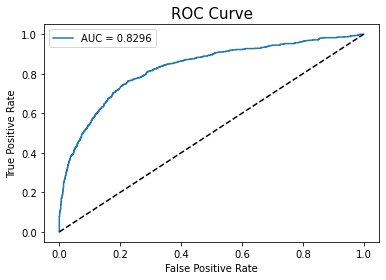

In [98]:
y_pred_proba = clf2.predict_proba(X_test)[:][:,1]

df_actual_predicted = pd.concat([pd.DataFrame(np.array(y_test), columns=['y_actual']), pd.DataFrame(y_pred_proba, columns=['y_pred_proba'])], axis=1)
df_actual_predicted.index = y_test.index
fpr, tpr, tr = roc_curve(df_actual_predicted['y_actual'], df_actual_predicted['y_pred_proba'])
auc = roc_auc_score(df_actual_predicted['y_actual'], df_actual_predicted['y_pred_proba'])

plt.plot(fpr, tpr, label='AUC = %0.4f' %auc)
plt.plot(fpr, fpr, linestyle = '--', color='k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve', size = 15)
plt.legend()

# Conclusion

In [99]:
# Result of Best Models (XGBoost is avoided as Training score is very high compared to testing)
result_df = pd.DataFrame({"Accuracy":[accuracy_score(y_test, y_test_pred),accuracy_score(y_test, bg_pred_test),accuracy_score(y_test, rfg_pred_test), accuracy_score(y_test, y_svmt_pred2)],
                         "Recall" :[recall_score(y_test, y_test_pred),recall_score(y_test, bg_pred_test),recall_score(y_test, rfg_pred_test), recall_score(y_test, y_svmt_pred2)],
                          "Precision" : [precision_score(y_test, y_test_pred),precision_score(y_test, bg_pred_test), precision_score(y_test, rfg_pred_test), precision_score(y_test, y_svmt_pred2)],
                          "F1_score" : [f1_score(y_test, y_test_pred),f1_score(y_test, bg_pred_test), f1_score(y_test, rfg_pred_test), f1_score(y_test, y_svmt_pred2)],
                          })

result_df.index= ["LogisticRegression(GS)","DecisionTree(Bagging)", "RandomForest(GS)", "SVM(GS)"]
result_df 

,Accuracy,Recall,Precision,F1_score
LogisticRegression(GS),0.730667,0.722397,0.420183,0.531323
DecisionTree(Bagging),0.839333,0.515773,0.651394,0.575704
RandomForest(GS),0.791333,0.662461,0.504808,0.572988
SVM(GS),0.786000,0.731861,0.495726,0.591083


SVM(kernel = 'poly', C = 1.75, gamma = 1, degree = 3) performs the best as F1_score and recall is the highest. Here, Precision is around 50%



An alternative would be Random Forest (criterion': 'gini', 'max_depth': 4, 'max_leaf_nodes': 5, 'min_samples_leaf': 1, 'min_samples_split': 2) which performs comparatively well (Slightly better Accuracy and Precision). An advantage would be a lower computation time.

Implementing SVM(kernel = 'poly', C = 1.75, gamma = 1, degree = 3)

The advantages of support vector machines (SVM) are:

- Effective in high-dimensional space.
- It is also memory efficient because it uses a subset of the training points in the decision function (called support vectors).
- Versatility: You can specify different kernel functions for the decision function. A generic kernel is provided, but it is possible to specify a custom kernel.
- SVM works relatively well when there is a clear margin of separation between classes.
- SVM is effective in cases where the number of dimensions is greater than the number of samples.


The disadvantages of support vector machines include:

- SVM algorithm is not suitable for large data sets.
- SVM does not perform very well when the data set has more noise i.e. target classes are overlapping.
- In cases where the number of features for each data point exceeds the number of training data samples, the SVM will underperform.
- As the support vector classifier works by putting data points, above and below the classifying hyperplane there is no probabilistic explanation for the classification.

# Challenges

- This project was a preliminary step in the banking sector. A well grounded knowledge would have helped shape the analysis process.
- Most machine learning algorithms used for classification are implicitly tuned to work best with equal distribution of the classes of data. In the used dataset features like country, churn were imbalanced.
- The size of the dataset was 10,000, however a larger dataset with customer transaction history would provide deeper insights.
- The aim for any Bank is to build a 360 relationship with the customer to avoid churn. Given the dataset understanding this relationship wasn't possible. So analysis of customer feedback form using nlp would help understand customer queries.
-Futher analysis could be conducted by banks to find features that represent “symptoms” of churn, like increasing withdrawals or dormant accounts, or, that represent the “drivers” of churns itself – such as difficult online experience, poor customer service or heavy fees on ATM withdrawals.


# End